In [1]:
from default_globals import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from utils import make_nice_plots
from scipy.stats import binom
import glob
make_nice_plots()

# xx = np.linspace(0, 1, 100)
# plt.figure()
# plt.plot(xx, 6 * xx, color='indigo', linewidth=3)
# plt.plot(xx, 5 * xx, color='navy', linewidth=3)
# plt.plot(xx, 4 * xx, color='teal', linewidth=3)
# plt.plot(xx, 3 * xx, color='goldenrod', linewidth=3)
# plt.plot(xx, 2 * xx, color='orangered', linewidth=3)
# plt.plot(xx, 1 * xx, color='crimson', linewidth=3)
# plt.show()

COLORS = ['orangered', 'navy', 'teal', 'goldenrod', 'indigo', 'crimson']


In [2]:
# from ligo.skymap.io.fits import read_sky_map
# from tqdm import tqdm

# SKYMAP_DIR = "/home/lucas/Documents/PhD/skymaps_moc_10k_2/"
# COORD_PATH = '/home/lucas/Documents/PhD/true_r_theta_phi_moc_10k_2.txt'

# for filename in tqdm(np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))):

#     skymap = read_sky_map(filename, moc=True)
#     nnans = np.sum(np.isnan(np.array(skymap['PROBDENSITY'])))
#     if nnans > 0:
#         print(nnans)
#         os.system(f'rm -rf {filename}')

# good_skymaps = np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))
# good_labels = [f[-13:-8] for f in good_skymaps]

# filtered_lines = []
# with open(COORD_PATH, 'r') as file:
#     for line in file:
#         columns = line.strip().split(',')

#         first_column_value = columns[0]
#         if first_column_value in good_labels:
#             filtered_lines.append(line)

# with open(COORD_PATH, 'w') as file:
#     file.writelines(filtered_lines)


In [3]:
# NEW_NAME = '2'

# # Relabel idx
# for filename in tqdm(np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))):
#     new_filename = filename[:-13] + NEW_NAME + filename[-12:]
#     os.rename(filename, new_filename)

# renamed_lines = []
# with open(COORD_PATH, 'r') as file:
#     for line in file:
#         columns = line.strip().split(',')
#         new_line = NEW_NAME + str(line)[1:]
#         renamed_lines.append(new_line)
# with open(COORD_PATH, 'w') as file:
#     file.writelines(renamed_lines)

In [4]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]


def get_cdfs(posteriors):
    posteriors -= np.max(posteriors, axis=0)
    pdf = np.exp(posteriors)
    cdfs = np.cumsum(pdf, axis=0)
    cdfs /= np.max(cdfs, axis=0)
    return cdfs


def get_pdfs(posteriors, axis):
    posteriors -= np.max(posteriors, axis=0)
    pdf = np.exp(posteriors)
    norms = simpson(y=pdf, x=axis, axis=0)  # Simpson should be fine...
    pdfs = pdf / norms
    return pdfs


def load_posteriors(path):
    posteriors = np.load(path)
    shape = posteriors.shape
    return posteriors, shape


In [105]:
from utils import uniform_shell_sampler
from redshift_utils import fast_z_at_value
import astropy.units as u

r, t, p = uniform_shell_sampler(COSMO.comoving_distance(1e-4).value, COSMO.comoving_distance(1.5).value, n_samps=80)
r2, t2, p2 = uniform_shell_sampler(COSMO.comoving_distance(1e-4).value, COSMO.comoving_distance(10).value, n_samps=int(1e3))
r_total = np.append(r, r2)
z_total = fast_z_at_value(COSMO.comoving_distance, r_total * u.Mpc)
z2 = fast_z_at_value(COSMO.comoving_distance, r2 * u.Mpc)

print(f'Expected number density within z=1.5: {np.sum(z2 < 1.5) / COSMO.comoving_volume(1.5)}')
print(f'Realized number density within z=1.5: {np.sum(z_total < 1.5) / COSMO.comoving_volume(1.5)}')

print(np.sum(z2 < 1.5))


Expected number density within z=1.5: 2.5007796968427776e-10 1 / Mpc3
Realized number density within z=1.5: 4.62910284309195e-10 1 / Mpc3
94


/tmp/ipykernel_5424/2767026664.py:8: RuntimeWarning: invalid value encountered in subtract
  posteriors -= np.max(posteriors, axis=0)


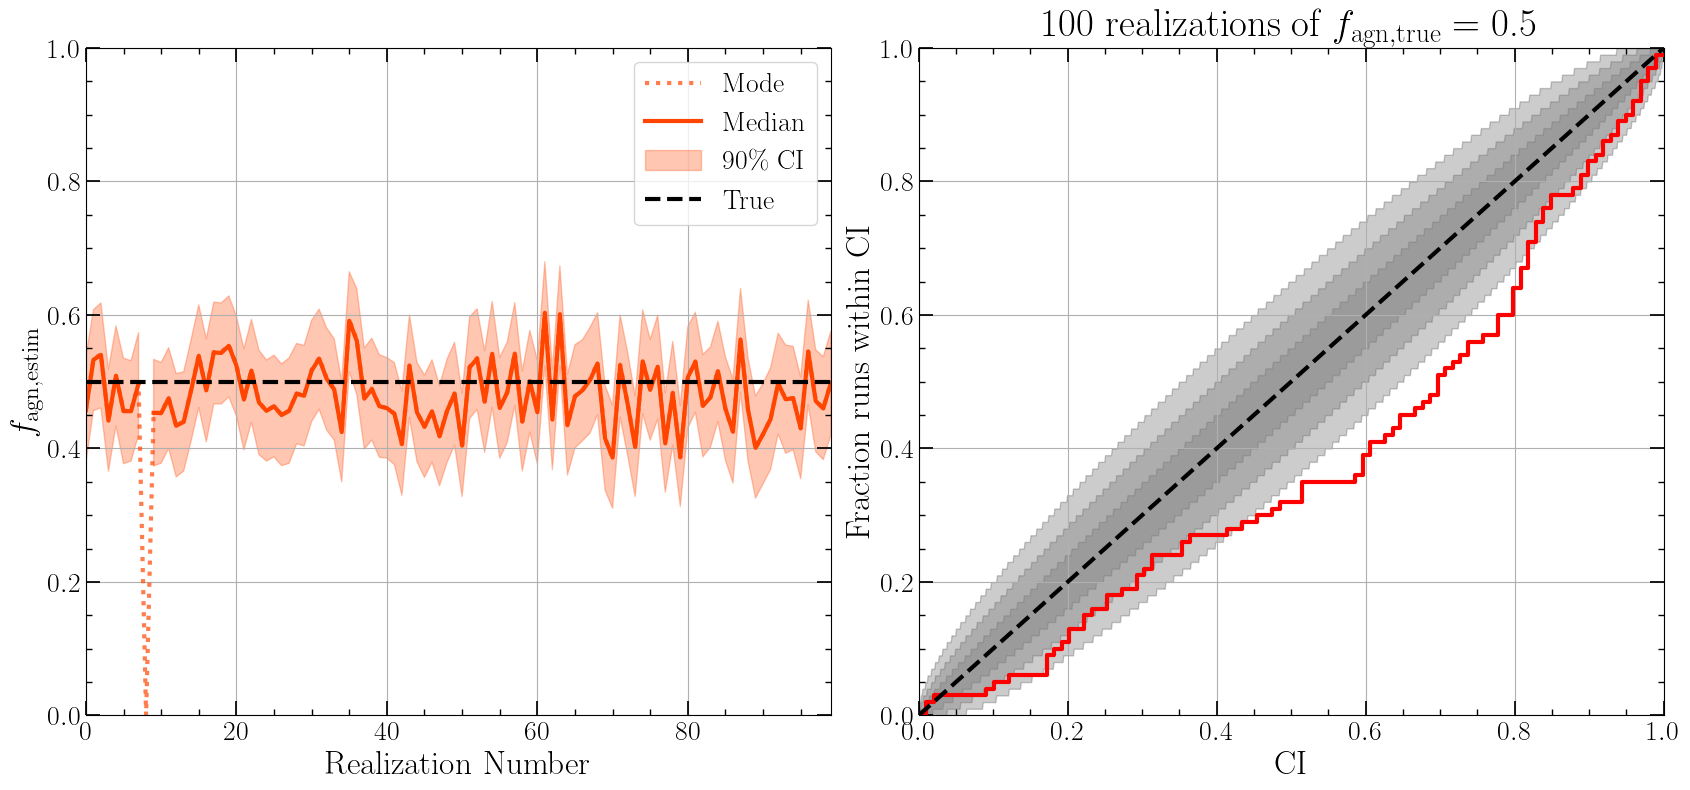

In [136]:
p26_posteriors, posteriors_shape = load_posteriors('./p26_likelihood_posteriors.npy')
datasets_list = [p26_posteriors]
# LABELS = [0]
FAGN_TRUE = 0.5

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
for idx, posterior in enumerate(datasets_list):
    nx = posterior.shape[1]
    xx = np.arange(nx)  #np.linspace(0, 1, posterior.shape[1])

    cdfs = get_cdfs(posterior)
    
    cdf_at_true_val = np.zeros(nx)
    q005 = np.zeros(nx)
    q050 = np.zeros(nx)
    q095 = np.zeros(nx)
    for i, cdf in enumerate(cdfs.T):
        inverse_cdf = interp1d(cdf, LOG_LLH_X_AX, bounds_error=False, fill_value='extrapolate')
        q005[i] = inverse_cdf(0.05)
        q050[i] = inverse_cdf(0.50)
        q095[i] = inverse_cdf(0.95)

        cdf_at_true_val[i] = interp1d(LOG_LLH_X_AX, cdf)(FAGN_TRUE)

    mode_fagns = LOG_LLH_X_AX[np.argmax(posterior, axis=0)]

    ax1.plot(xx, mode_fagns, color=COLORS[idx], alpha=0.7, linewidth=3, linestyle='dotted', label='Mode')
    ax1.plot(xx, q050, color=COLORS[idx], linewidth=3, label='Median')
    ax1.fill_between(xx, q005, q095, color=COLORS[idx], alpha=0.3, label=r'90$\%$ CI')
ax1.hlines(FAGN_TRUE, 0, nx - 1, linestyle='dashed', color='black', zorder=6, linewidth=3, label='True')
ax1.legend()
ax1.set_xlabel(r'Realization Number')
ax1.set_ylabel(r'$f_{\rm agn, estim}$')
ax1.grid()
ax1.set_xlim(0, nx - 1)
ax1.set_ylim(0, 1)

# plt.figure(figsize=(8,8))

Nrep = len(cdf_at_true_val)
comparisons = np.linspace(0, 1, Nrep)
pp_plot = np.zeros(Nrep)
for i in range(len(pp_plot)):
    pp_plot[i] = np.sum(cdf_at_true_val <= comparisons[i])
pp_plot /= len(cdf_at_true_val)

CI = np.linspace(0, 0.9999, 1000)
for ci, alpha in zip([0.6827, 0.9545, 0.9973], [0.1,0.15,0.2]):
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, Nrep, CI) / Nrep
    upper = binom.ppf(edge_of_bound, Nrep, CI) / Nrep
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

ax2.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
ax2.step(comparisons, pp_plot, linewidth=3, color='red')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_title(str(Nrep) + ' realizations of ' + r'$f_{\rm agn, true} =$ ' + str(FAGN_TRUE))
ax2.set_xlabel('CI')
ax2.set_ylabel('Fraction runs within CI')
plt.tight_layout()
plt.show()
